## GNN Applications

In [ ]:
# library setup
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv,ChebConv, GATConv
from torch_geometric.datasets import KarateClub, Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_dense_adj
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import graphviz
import networkx as nx
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import os

### Domains of Applications

[Visualization Example](https://xentenza.github.io/bluenote/network/#)


<figure>
<center>
<img src='https://images.datacamp.com/image/upload/v1658404112/Community_Graph_7f57ef95f9.png'
width='500px' />
<figcaption>Jazz Musicians Network. Source: DataCamp</figcaption></center>
</figure>


#### Social Networks:

**SNAP Datasets:** Stanford Network Analysis Project provides a collection of social network datasets, including friendship networks (e.g., Facebook, Pokec) and citation networks (e.g., Cora, Citeseer). These are excellent for recommendation systems, community detection, and information diffusion tasks.


#### Knowledge Graphs:

**WordNet:** A lexical database for English that can be represented as a knowledge graph. It's useful for tasks like knowledge graph completion and relation extraction.

**Freebase:** A large collaborative knowledge base containing general facts about the world. Though it's no longer actively maintained, it's still valuable for research.

#### Chemistry and Drug Discovery:

**PubChem:** A public database of chemical molecules and their properties. It's widely used for molecular property prediction and drug discovery research.

**ChEMBL:** A manually curated database of bioactive molecules with drug-like properties. It's valuable for drug-target interaction prediction and other tasks in drug discovery.


#### Traffic Prediction:

**PeMS:** California Department of Transportation Performance Measurement System provides traffic data from sensors on highways, which can be used for traffic flow forecasting.


#### Cross-References and Citations:

**Cora Dataset:** Commonly used for node classification tasks in GNNs. It consists of scientific publications categorized into different topics.

**Reddit Datasets:** Various datasets based on Reddit interactions, which can be used for graph-based machine learning tasks.

**Open Graph Benchmark (OGB):** A collection of benchmark datasets for graph machine learning tasks, including node classification, link prediction, and graph classification.
Additionally, many research papers in the GNN field often provide access to their datasets for reproducibility and further research. You can find these in the supplementary materials or appendices of the papers.

To find these datasets, you can search for them by name on platforms like Google Dataset Search or Kaggle. You can also look for repositories on GitHub where researchers share their datasets.

### Citations Application

Planetoid is a dataset consisting of three citation networks (Cora, CiteSeer, PubMed) suitable for semi-supervised learning tasks.  Nodes correspond to documents represented by bag-of-words feature vectors in 1433-dimensional space. Edges represent citation links. The objective is to develop a model capable of accurately predicting the class labels (cardinality seven) of unlabeled documents within the network.

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1693)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=80, c=color, cmap="Set2")
    plt.show()

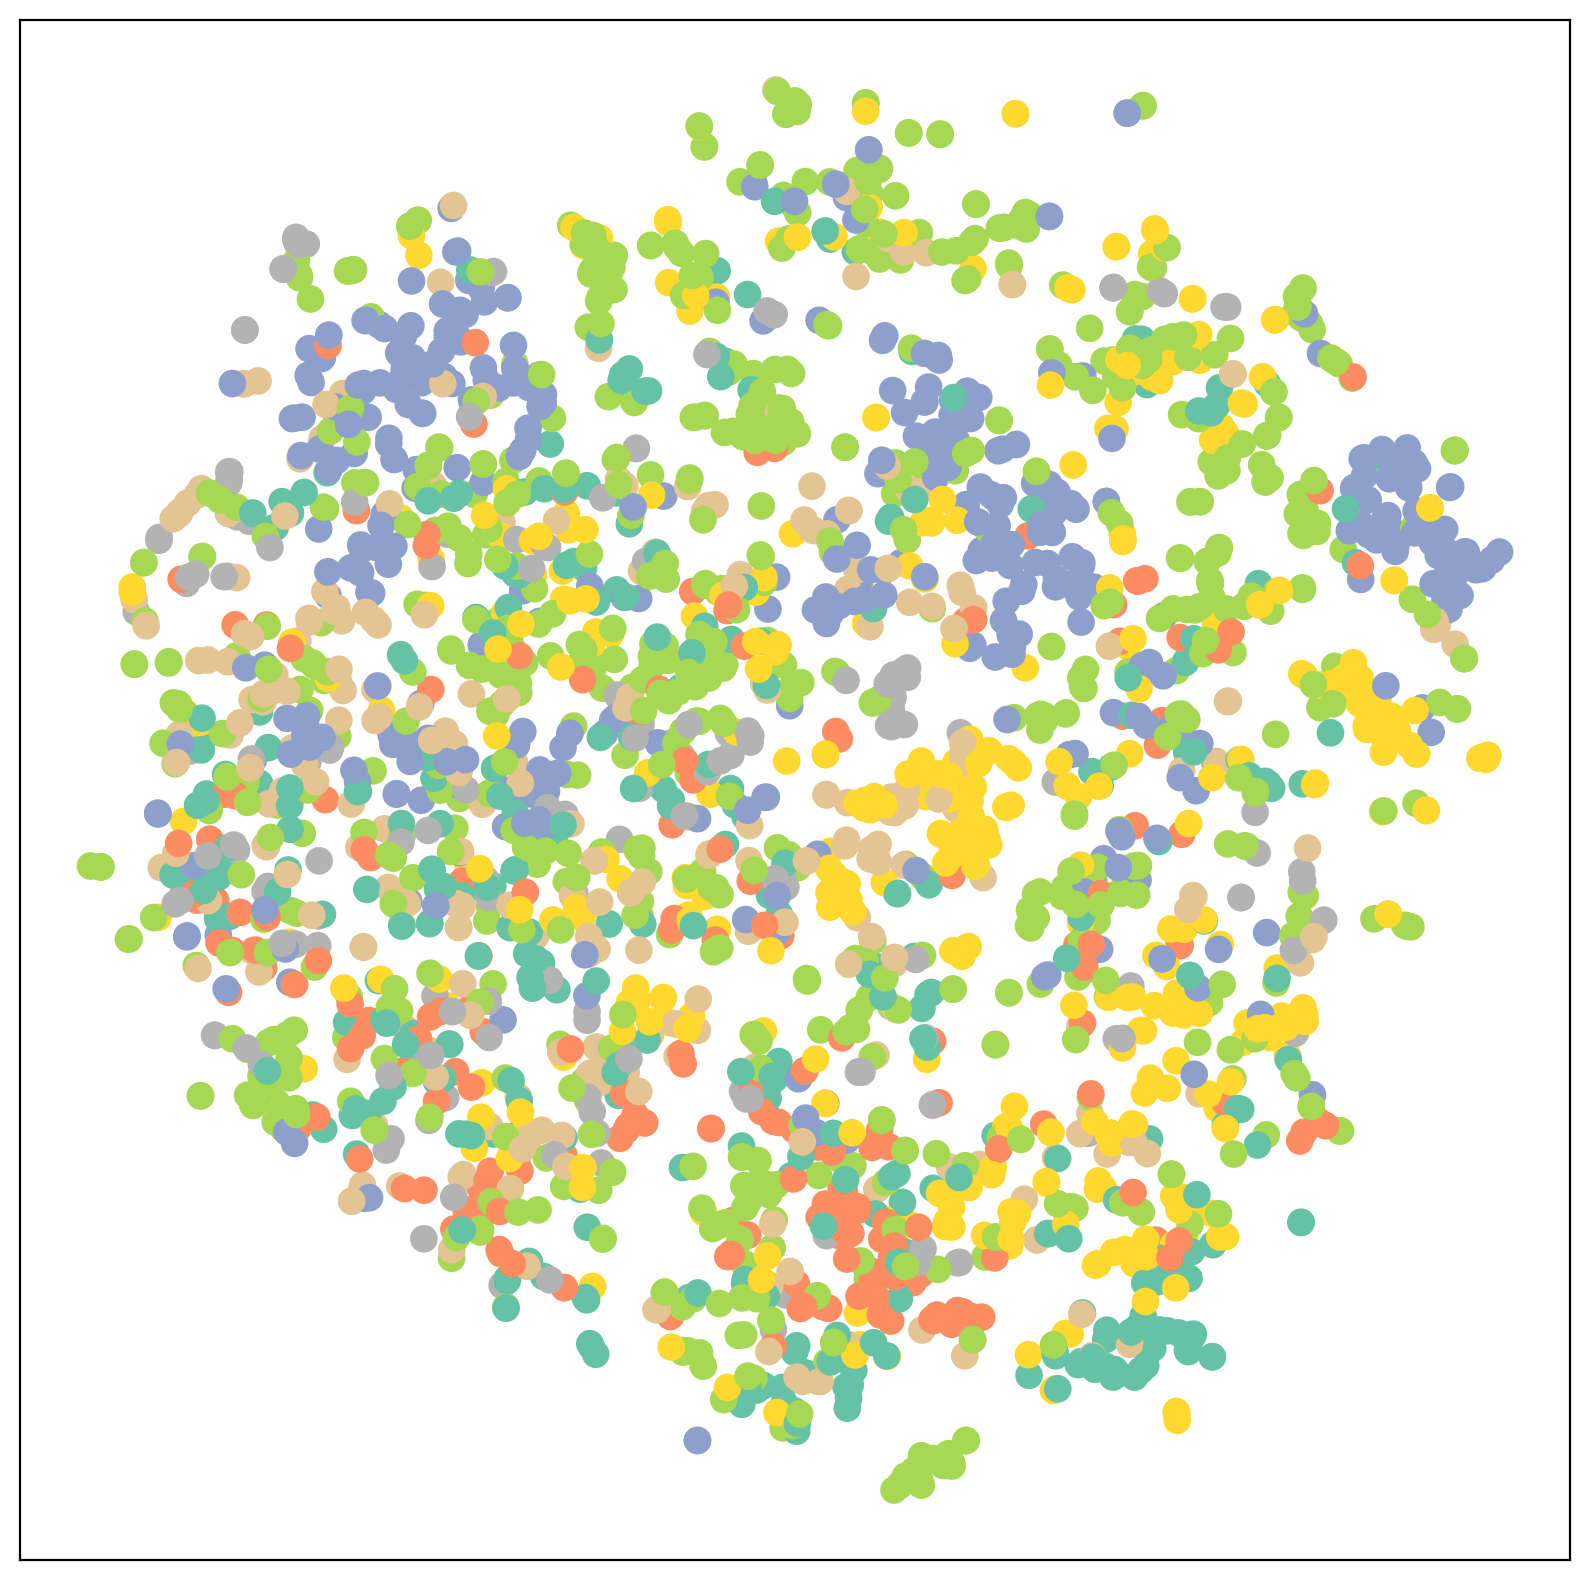

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9454
Epoch: 002, Loss: 1.9400
Epoch: 003, Loss: 1.9324
Epoch: 004, Loss: 1.9238
Epoch: 005, Loss: 1.9130
Epoch: 006, Loss: 1.9063
Epoch: 007, Loss: 1.8933
Epoch: 008, Loss: 1.8844
Epoch: 009, Loss: 1.8732
Epoch: 010, Loss: 1.8565
Epoch: 011, Loss: 1.8434
Epoch: 012, Loss: 1.8331
Epoch: 013, Loss: 1.8175
Epoch: 014, Loss: 1.8042
Epoch: 015, Loss: 1.7850
Epoch: 016, Loss: 1.7770
Epoch: 017, Loss: 1.7594
Epoch: 018, Loss: 1.7362
Epoch: 019, Loss: 1.7343
Epoch: 020, Loss: 1.7052
Epoch: 021, Loss: 1.6975
Epoch: 022, Loss: 1.6723
Epoch: 023, Loss: 1.6563
Epoch: 024, Loss: 1.6449
Epoch: 025, Loss: 1.6239
Epoch: 026, Loss: 1.6007
Epoch: 027, Loss: 1.5857
Epoch: 028, Loss: 1.5602
Epoch: 029, Loss: 1.5430
Epoch: 030, Loss: 1.5243
Epoch: 031, Loss: 1.4860
Epoch: 032, Loss: 1.4897
Epoch: 033, Loss: 1.4719
Epoch: 034, Loss: 1.4405
Epoch: 035, Loss: 1.4162
Epoch: 036, Loss: 1.3896
Epoch: 037, Loss: 1.3707
Epoch: 038, Loss: 1.3397
Epoch: 039, Loss: 1.3199
Epoch: 040, Loss: 1.2892


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8220


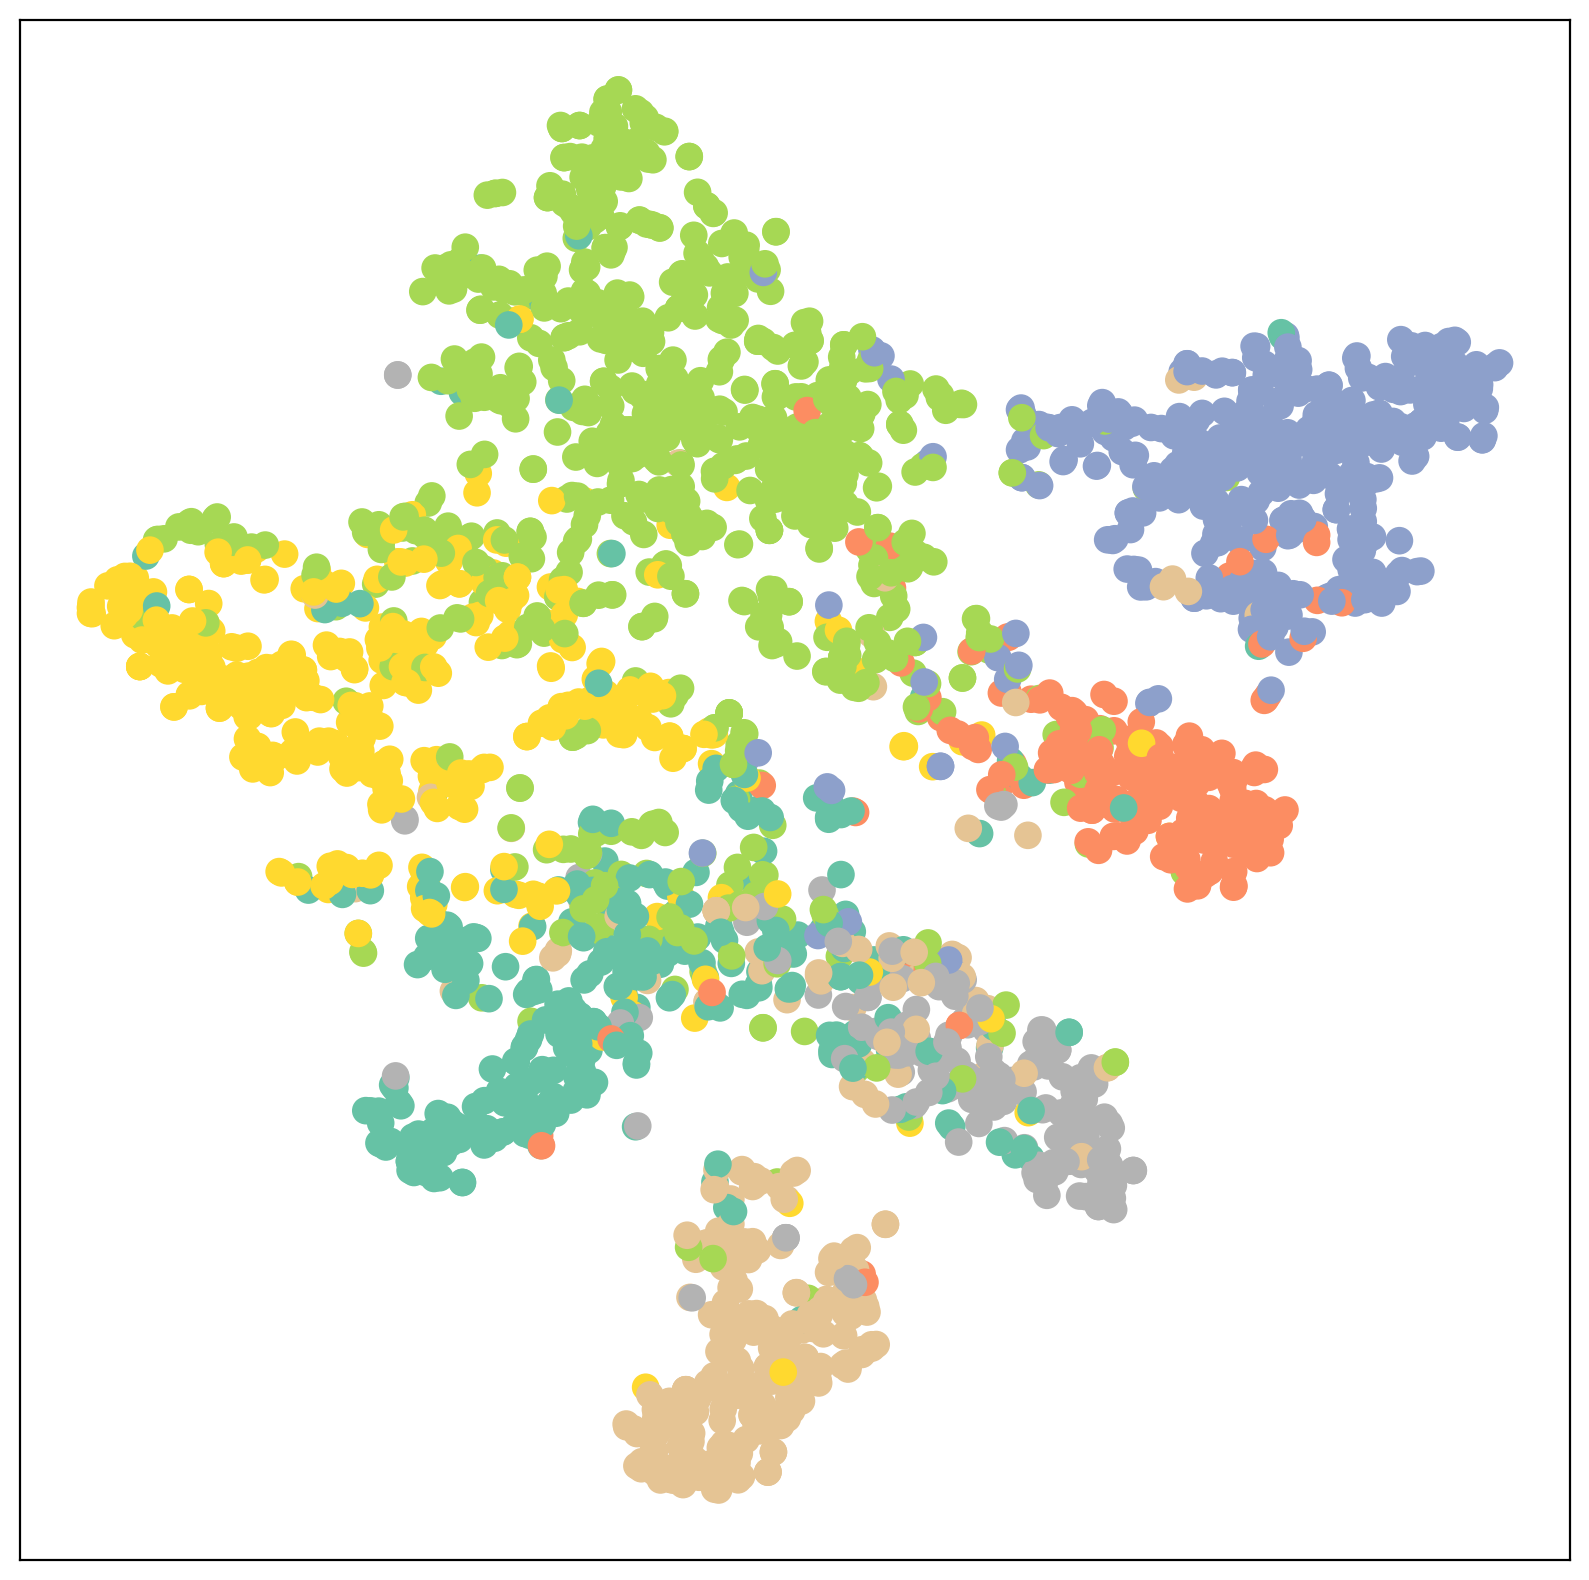

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Example with Graph Attention Networks

#### Graph Attention Networks (GATs)

GATs are a type of Graph Neural Network (GNN) that leverage the concept of attention mechanisms, borrowed from the field of natural language processing (NLP), to enhance the way information is aggregated from neighboring nodes in a graph.

#### Key Advantages:

**Attention Mechanism:** GATs don't just treat all neighbors equally. They learn to assign different importance (attention) to different nodes in the neighborhood based on their features and the structure of the graph. This allows the network to focus on the most relevant nodes for a given task.

**Improved Performance:** This attention mechanism often leads to improved performance over traditional graph convolutional networks (GCNs) on various tasks, especially when the graph structure is complex or the node features are rich and informative.

**Flexibility:** GATs can handle graphs with variable-sized neighborhoods, which is a limitation of some other GNN architectures.

#### GATConv (Graph Attentional Convolution Layer)

GATConv is the fundamental building block of a GAT. It's the layer that performs the graph attentional convolution operation, where the attention mechanism is applied. Here's how it works:

**Node Feature Transformation:** Each node's feature vector is linearly transformed to a higher dimensional space.

**Attention Coefficients Calculation:** Pairs of nodes (a node and its neighbors) are considered. The attention mechanism computes a score (attention coefficient) for each pair, indicating how much attention the node should pay to its neighbor. This score is usually based on the transformed features of both nodes and can optionally include structural information (e.g., edge features).

**Normalization:** The attention coefficients are normalized (often using a softmax function) so that they sum to 1 for each node across all its neighbors.

**Weighted Aggregation:** The transformed features of the neighbors are aggregated using the normalized attention coefficients as weights. This means that the final node representation is a weighted sum of its neighbors' features, where the weights are learned through the attention mechanism.

**Optional Nonlinearity:** An activation function (e.g., ReLU) may be applied to the aggregated representation to introduce non-linearity.

#### Multi-Head Attention:

GATs often employ multi-head attention, which means that the attentional convolution is performed multiple times independently, each with its own set of parameters. The results of these multiple heads are then combined, usually by concatenation or averaging, to produce the final node representation. This improves the model's capacity to capture different aspects of the node features and graph structure.


#### Applications Include:

**Node Classification:** Predicting the type or label of a node in a graph (e.g., social network analysis, recommender systems).
**Link Prediction:** Predicting the existence of a connection between two nodes (e.g., knowledge graph completion).
**Graph Classification:** Predicting the overall type or label of an entire graph (e.g., chemical compound analysis).

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1693)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 55):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0235, Val: 0.3520, Test: 0.3390
Epoch: 002, Loss: 3.9928, Val: 0.4680, Test: 0.4670
Epoch: 003, Loss: 3.9566, Val: 0.4720, Test: 0.4630
Epoch: 004, Loss: 3.9169, Val: 0.4540, Test: 0.4640
Epoch: 005, Loss: 3.8716, Val: 0.4480, Test: 0.4560
Epoch: 006, Loss: 3.8131, Val: 0.4500, Test: 0.4540
Epoch: 007, Loss: 3.7573, Val: 0.4460, Test: 0.4500
Epoch: 008, Loss: 3.6841, Val: 0.4440, Test: 0.4470
Epoch: 009, Loss: 3.6124, Val: 0.4440, Test: 0.4440
Epoch: 010, Loss: 3.5408, Val: 0.4360, Test: 0.4400
Epoch: 011, Loss: 3.4490, Val: 0.4360, Test: 0.4370
Epoch: 012, Loss: 3.3485, Val: 0.4280, Test: 0.4300
Epoch: 013, Loss: 3.2494, Val: 0.4220, Test: 0.4250
Epoch: 014, Loss: 3.1402, Val: 0.4040, Test: 0.4120
Epoch: 015, Loss: 3.0328, Val: 0.3920, Test: 0.4000
Epoch: 016, Loss: 2.9350, Val: 0.3840, Test: 0.3860
Epoch: 017, Loss: 2.8407, Val: 0.3700, Test: 0.3800
Epoch: 018, Loss: 2.6960, Val: 0.3620

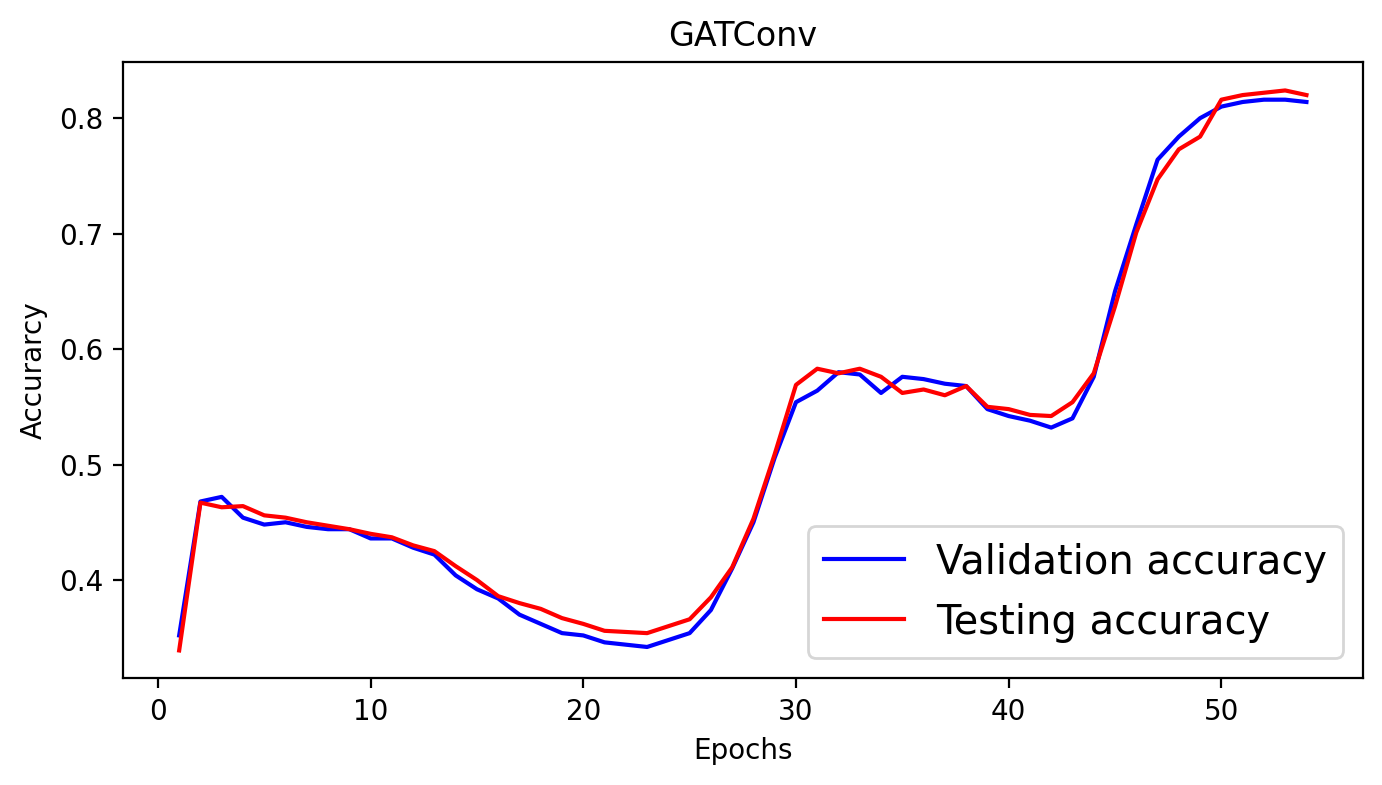

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

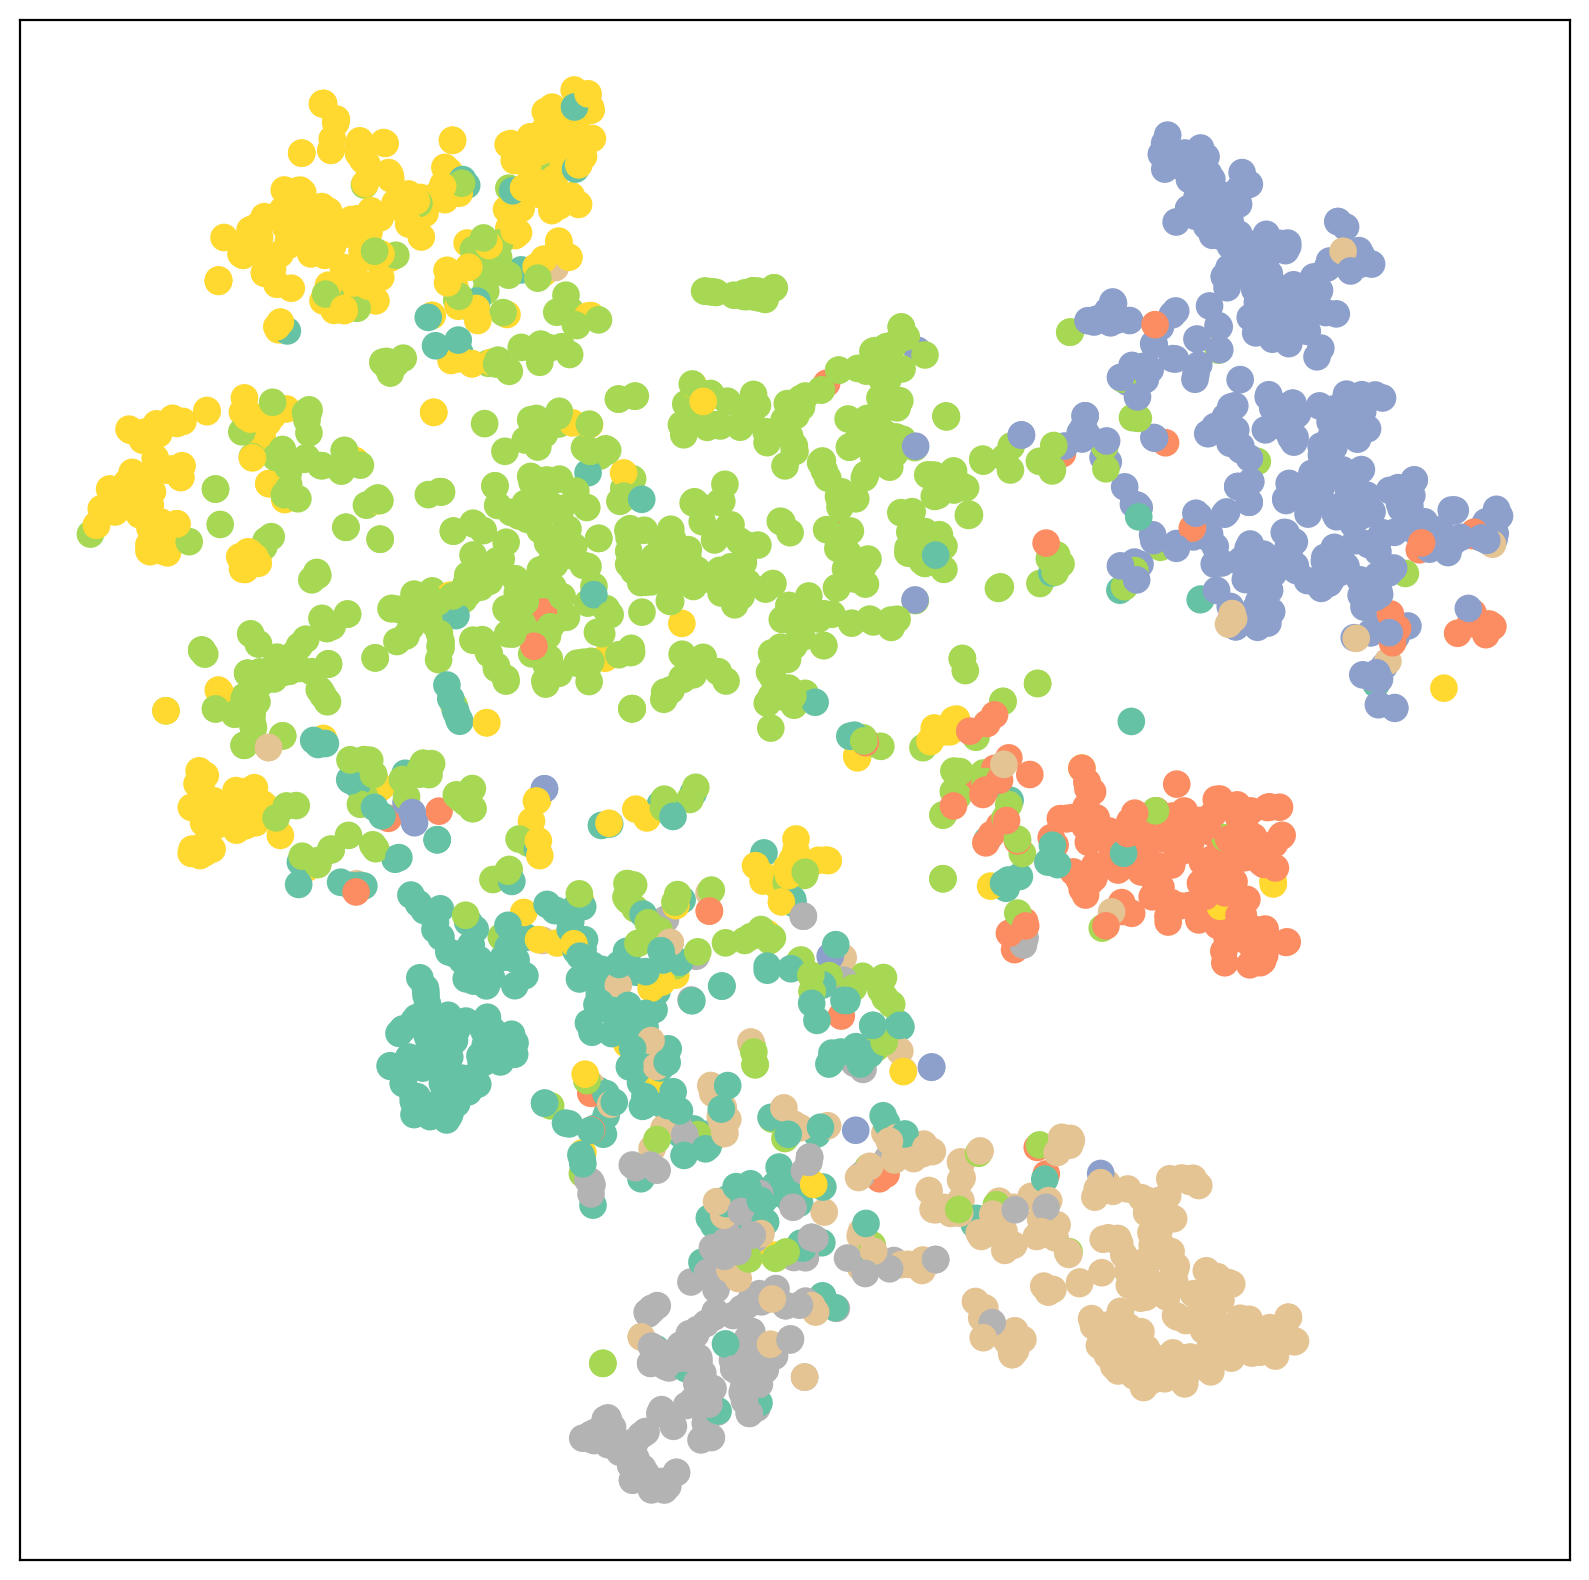

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)